# The different pictures of linear least squares
When presented with a set of points and asked to fit a line through it, we typically start by defining a linear model with some parameters. For example, with a 1-dimensional input, the familiar equation *y = m x + c* is a suitable model where the slope *m* and y-intercept *c* are parameters that need to be estimated. Given a new input *xₙ*, the model with optimal parameters allows us to make a reasonable prediction *yₙ*.

Let's look at a concrete example from the first recorded application of linear (in the parameters) least squares [2]. In the late eighteenth-century, mathematicians were busy trying to fit a model to capture the variation in the Earth's curvature with increasing latitude. They hypothesized that the length Δ*s* of an arc Δ*λ* of a meridian at the geodetic latitude *λ* takes the form

<!-- $$\frac{\Delta s}{\Delta \lambda} = c_0 + c_1 \sin^2{\lambda}$$ . -->
![eq:geodetic](latex_images/geodetic.png)

Notice that the function is not linear in inputs due to the sin² term but continues to be *linear in the parameters*. Their work used data from a series of French surveys conducted a few years earlier in far-off places, with samples ranging from the equatorial to the arctic regions. Here is a table detailing some of the locations, along with a regular 2D plot.

<!-- | ID    | Location     | Latitude $\lambda$ | $\Delta s/\Delta \lambda$ |
| :---: | :---:        | :---:              | :---:                     |
| 1     | Peru         | 0                  | 25538.85                  |
| 2     | Good Hope    | 37.0093            | 25666.65                  |
| 3     | Pennsylvania | 43.5556            | 25599.6                   |
| 4     | Italy        | 47.7963            | 25640.55                  |
| 5     | France       | 51.3327            | 25658.28                  |
| 6     | Austria      | 53.0926            | 25683.3                   |
| 7     | Lapland      | 73.7037            | 25832.25                  |
 -->

![fig:geodetic data](images/data.jpeg)

Data collected in French surveys [1] in the early 1700s. All lengths are reported in double toises (1/0.256537 m) and angles in gradians (2π/400). The relationship is not strictly linear, but we will perform linear regression.

In [1]:
# from plot_utils import *
# import matplotlib.pyplot as plt

# x, y, _, labels = get_linear_system('survey_data')

# _, ax = plt.subplots()
# ax.scatter(x, y, color='g');
# for loc, x_i, y_i in zip(labels, x, y):
#     ax.annotate(loc, (x_i, y_i + 6), ha='center', va='bottom')

# labels_2d(ax)

Linear regression aims to estimate the parameters of a linear model with the help of such training data. The canonical approach to regression is to compute and minimize an error between model predictions and ground truths.  A popular choice is the sum of all the squared differences, and although this isn't the only viable error function, it is the most popular one and we will use the sum of squared errors throughout this article. This encompasses the set of approximate methods called *linear least squares*. We will see how different branches of mathematics approach the problem using vastly different pictures.

## Calculus picture
The geodetic model has only two parameters *c₀* and *c₁*. Representing each data point in the training data as *(xᵢ,yᵢ)* where *i* is the row index from the table above, high-school calculus yields optimal values for the parameters. This is done by differentiating the error w.r.t. each parameter and equating to 0. The resulting system of simultaneous equations contains as many equations as parameters and is solved using Gaussian elimination

<!-- $$\mathcal{L} = \sum_{i=1}^{n} (y_i - \hat{y}_i )^2 = \sum_{i=1}^{n} (y_i - (c_0 + c_1 x_i))^2$$
$$\hat{c}_0 = \underset{c_0}{\mathrm{arg\,min}}\,\mathcal{L} = \bar{y} - \hat{c}_1 \bar{x}\,; \quad \hat{c}_1 = \underset{c_1}{\mathrm{arg\,min}}\,\mathcal{L} = \frac{\sum_{i=1}^{n} (x_i - \bar{x}) (y_i - \bar{y})}{\sum_{i=1}^{n} (x_i - \bar{x})^2}\,.$$ -->
![eq:calculus_least_squares](latex_images/calculus_LS.png)

This is actually the ordinary least squares (OLS) approximation for the linear system. As we will see, other approximations also exist. For simple low-dimensional systems, we can visualize the surface of the error function. It might not look like the minimum is unique but I ask you to trust the math!

In [52]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
from plot_utils import *

x, y, _, _ = get_linear_system('survey_data')
c_0 = np.linspace(25000, 26000)
c_1 = np.linspace(-1000, 1000)
c_0_xx, c_1_yy = np.meshgrid(c_0, c_1)

errs = y[np.newaxis, np.newaxis, :] - c_0_xx[..., np.newaxis] - c_1_yy[..., np.newaxis]*x[np.newaxis, np.newaxis, :]
sum_sq_errs = np.sum(errs**2, axis=-1)
ax = plt.subplot(projection='3d')
ax.plot_surface(c_0_xx, c_1_yy, sum_sq_errs, alpha=0.5)

# Ordinary least squares
x_bar, y_bar = x.mean(), y.mean()
c_1_ols = ((x - x_bar) * (y - y_bar)).sum() \
          / ((x - x_bar)**2).sum()
c_0_ols = y_bar - c_1_ols * x_bar
c_ols = [c_0_ols, c_1_ols, np.sum((y - c_0_ols[..., np.newaxis] - c_1_ols*x)**2)]
ax.scatter(*c_ols, color='r', marker='x')
c_ols[2] -= 1000
ax.text(*c_ols, 'Minima', va='top')
ax.set_xticks([]), ax.set_yticks([]), ax.set_zticks([])

save_animation(ax, 'images/loss.gif')

![fig:loss](images/loss.gif)

### Weighted least squares
The different data points may not be equally reliable, and we may have evidence to believe that some errors in the sum should be weighted more than others. By ignoring such additional information, we end up with sub-optimal approximations that are strongly affected by outliers. In the example presented above, perhaps the surveyors admitted that collecting accurate data proved challenging in some regions, such as the equatorial rainforests in Peru or the Cape Peninsula. In Lapland, perhaps heavy snow posed great difficulties resulting in a worse measurement. Armed with this additional information, we replace the error function with a weighted sum of the squared errors and proceed with partial differentiation as earlier. The least squares approximation needs a small modification, resulting in the weighted least squares (WLS) solution. You should try to derive the formula yourself. Let's use weights of 0.25 for the snow affected Lapland region, 0.5 for the slightly errenous measurements, and stick to 1 for the others.

25516.26039871393 282.79566187844523


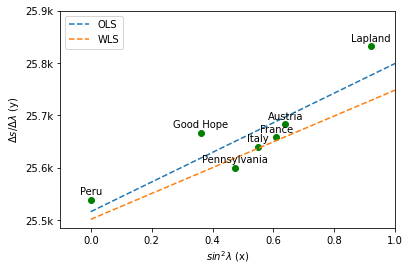

In [2]:
x, y, w, labels = get_linear_system('survey_data')

# Ordinary least squares
x_bar, y_bar = x.mean(), y.mean()
c_1_ols = ((x - x_bar) * (y - y_bar)).sum() \
          / ((x - x_bar)**2).sum()
c_0_ols = y_bar - c_1_ols * x_bar
print(c_0_ols, c_1_ols)

# Weighted least squares
x_w_bar, y_w_bar = (w * x).sum() / w.sum(), (w * y).sum() / w.sum()
c_1_wls = (w * (x - x_w_bar) * (y - y_w_bar)).sum() \
          / (w * (x - x_w_bar)**2).sum()
c_0_wls = y_w_bar - c_1_ols * x_w_bar

x_continuous = np.linspace(0, 1)
y_ols = c_0_ols + c_1_ols * x_continuous
y_wls = c_0_wls + c_1_wls * x_continuous

_, ax = plt.subplots()
ax.plot(x_continuous, y_ols, '--', label='OLS')
ax.plot(x_continuous, y_wls, '--', label='WLS')
ax.scatter(x, y, color='g');
for loc, x_i, y_i in zip(labels, x, y):
    ax.annotate(loc, (x_i, y_i + 6), ha='center', va='bottom')

labels_2d(ax, legend=True)

## Linear algebra picture
Moving on to multiple input parameters, it becomes imperative to work with vectors and matrices. You can continue with the same picture and use multivariable calculus, but some people prefer a different, geometric view - the linear algebra picture. Let's represent our linear system of *k* input features and *n* equations using vector-matrix notation (with bold capital letters representing matrices and bold small letters representing vectors): **Xc = y**, or

<!-- $$\begin{bmatrix}
x_{11} & x_{12} & \dots  & x_{1k} \\
x_{21} & x_{22} & \dots  & x_{2k} \\
\vdots & \vdots & \ddots & \vdots \\
x_{n1} & x_{n2} & \dots  & x_{nk} \\
\end{bmatrix} \cdot
\begin{bmatrix} c_{0} \\ c_{1} \\ \vdots \\ c_{k} \end{bmatrix} =
\begin{bmatrix} y_{1} \\ y_{2} \\ \vdots \\ y_{n} \end{bmatrix}\,.$$ -->
![eq:Xc=y](latex_images/linear_system.png)

In his [18-06](https://ocw.mit.edu/courses/mathematics/18-06-linear-algebra-spring-2010/) linear algebra course, Gilbert Strang introduces the column space picture of matrix multiplication and postulates that solving any linear system is equivalent to finding coefficients to express **y** as a linear combination or weighted average of the columns of **X**. The problem with real-world overconstrained systems is that **y** lies outside the column space of **X** i.e. no linear combination of the columns of **X** exactly yield **y**. The least squares solution is simply the projection of the vector **y** onto the subspace spanned by the columns of ***X***. Intuitively, this projection **ŷ** is the vector in the column space that is *closest* (according to some measure of error) to **y**. 

Unfortunately, the only way modest 3-dimensional beings like us can visualize this is by considering a trivial system consisting of three equations with two parameters. Let's use Peru, Italy, and Lapland from the table and look at the output vector, along with its projection on the column space. Additionally, to better see the picture, we will change the output vector slightly and consider a system of unit vectors.

In [25]:
%%capture
X, y, _, labels = get_filtered_linear_system('survey_data')

# Normal to the column space plane
normal = np.cross(X[:,0], X[:,1])
xx, yy = np.meshgrid(np.linspace(-.2, 1), np.linspace(-.2, 1))
z = (-normal[0]*xx -normal[1]*yy) / normal[2]

# Project y to the subspace
y_hat = X @ np.linalg.inv(X.transpose() @ X) @ X.transpose() @ y

ax = plt.subplot(projection='3d')
ax.quiver(*np.zeros(3), *X[:,0], arrow_length_ratio=0.1)
ax.quiver(*np.zeros(3), *X[:,1], arrow_length_ratio=0.1)
ax.quiver(*np.zeros(3), *y, arrow_length_ratio=0.1, color='g')
ax.quiver(*np.zeros(3), *y_hat, arrow_length_ratio=0.1, color='c')
ax.plot(*[(c1, c2) for c1, c2 in zip(y_hat, y)], color='r', linestyle='--')
ax.plot_surface(xx, yy, z, alpha=0.5)

ax.text(*y, '$\mathbf{y}$')
ax.text(*y_hat, '$\mathbf{\hat{y}}$')
ax.text(*X[:,0], '$\mathbf{x_{\star 1}}$')
ax.text(*X[:,1], '$\mathbf{x_{\star 2}}$')

labels_3d(ax)
# save_animation(ax, 'images/projection.gif')

![fig:projection](images/projection.gif)

Since the projection **ŷ** serves as an approximation of **y**, the resulting error is simply the difference between them, **e** = **y** - **ŷ** (red dotted line). In reality, **e** is perpendicular to every vector in the column space of **X** and, to be precise, is a member of its left nullspace. Thus, the inner product ⟨**Xᵀ**,**e**⟩ is the **0** vector

<!-- $$\langle \mathbf{X^T}, \mathbf{e}\rangle = \mathbf{0}$$
$$\mathbf{X^T}(\mathbf{y} - \mathbf{\hat{y}}) = \mathbf{X^T} (\mathbf{y} - \mathbf{X\hat{c}}_{\scriptscriptstyle OLS}) = \mathbf{0}$$
$$\implies \mathbf{\hat{c}}_{\scriptscriptstyle OLS} = (\mathbf{X^T}\mathbf{X})^{-1} \mathbf{X^T} \mathbf{y}\,.$$ -->
![eq:geometric_ordinary_least_squares](latex_images/la_OLS.png)

This is equivalent to the OLS solution obtained earlier. An important step here is the inversion of **XᵀX**, which requires the columns of **X** to be independent. With this picture, both the tractability and the uniqueness of the OLS approximation become evident.

## What about weights?
Rearranging the weights into a diagonal matrix **W**, the geometric linear algebra picture holds even for the WLS approximation. We replace the inner product from the previous derivation with a weighted inner product [1]

<!-- $$\langle \mathbf{X^T}, \mathbf{e} \rangle _\mathbf{W} = \mathbf{0}$$
$$\implies \mathbf{\hat{c}}_{\scriptscriptstyle WLS} = (\mathbf{X^T W X})^\mathbf{-1} \mathbf{X^TWy}\,.$$ -->
![eq:geometric_weighted_least_squares](latex_images/la_WLS.png)

This expression is a special case of a more general solution called generalized least squares. However, to get a better intuition we need to view the problem through the lens of probability.

## Probability picture
When dealing with data that contains measurement errors, it is natural to rely on probability theory, a branch of mathematics developed specifically for this purpose. Texts on probabilistic machine learning such as Christopher Bishop's excellent [PRML](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/) often begin with this view of linear least squares. To produce results consistent with our earlier pictures, we will assume that the error in each data point is a random variable drawn from a zero-mean Gaussian distribution with unknown variance σ. Each observation can be represented as

<!-- $$y_i = \mathbf{c x_i^T} + e\, \quad \, \textrm{where}\, e \sim \mathcal{N}(0, \sigma)$$
$$\mathrm{or}\,\, y_i \sim \mathcal{N}(\mathbf{cx_i^T}, \sigma)$$
$$\implies p(y_i|\mathbf{c}, \mathbf{x_i^T}, \sigma) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp{-\frac{1}{2}\left(\frac{y_i - c_i \mathbf{x_i^T}}{\sigma}\right)^2}\,.$$ -->
![eq:1D gaussian_sample](latex_images/gaussian_1d.png)

Since σ is constant, assuming each sample is independent and performing maximum likelihood estimation (MLE) produces the familiar expression,

<!-- $$\begin{align}
\mathbf{\hat{c}}_{\scriptscriptstyle OLS} &= \underset{\mathbf{c}}{\mathrm{arg\,max}}\, \prod_{i=1}^n p(y_i|\mathbf{c}, \mathbf{x_i^T})\\
&= \underset{\mathbf{c}}{\mathrm{arg\,min}}\, \sum_{i=1}^n(y_i - c_i\mathbf{x_i^T})^2\,.
\end{align}
$$ -->
![eq:maximum likelihood estimation](latex_images/MLE.png)

It turns out that computing the Euclidean errors and minimizing the sum of their squares is equivalent to MLE under the assumption of constant Gaussian noise! This is a reasonable assumption for real systems because the error is a byproduct of interference from potentially many different sources as explained in [this post](http://gregorygundersen.com/blog/2019/02/01/clt/). Hence, the *central limit theorem* validates the Gaussian as a suitable model for the additive noise. Different error functions in the calculus derivation correspond to different definitions of the inner product in the linear algebra derivation and different likelihoods in the probability derivation. Papers in computer vision for instance use the absolute difference as an error function, which can be derived under a Laplacian distribution.

## Weighted and generalized least squares
A natural extension is to look at what happens if each error is no longer restricted to be drawn from the same Gaussian. The samples are still independent but no longer identically distributed and out pops WLS formulation. The probability picture also enables us to reason about the possibility of the errors being correlated. This is the setup for generalized least squares where all the errors are drawn from a k-dimensional multivariate Gaussian with mean 0 and covariance matrix Σ. Proceeding with MLE we end up with the following multivariate minimization,

<!-- $$\mathcal{L} = \frac{1}{\sqrt{(2\pi)^k\Sigma^{-1}}} \, \exp\frac{-1}{2}(\mathbf{y} - \mathbf{Xc}) \mathbf{^T}  \mathbf{\Sigma^{-1}} (\mathbf{y} - \mathbf{Xc})$$
\begin{align}
\frac{\partial \log\mathcal{L}}{\partial \mathbf{c}} &= \frac{-1}{2} \cdot 2 \, (\mathbf{y} - \mathbf{Xc}) \mathbf{^T} \mathbf{\Sigma^{-1}} \cdot \frac{\partial (\mathbf{y} - \mathbf{Xc})}{\partial \mathbf{c}} \\
&= (\mathbf{y} - \mathbf{Xc}) \mathbf{^T} \mathbf{\Sigma^{-1}} \mathbf{Xc} = \mathbf{0}
\end{align}
$$\implies \mathbf{\hat{c}}_{\scriptscriptstyle GLS} = (\mathbf{X^T \Sigma^{-1} X})^\mathbf{-1} \mathbf{X^T \Sigma^{-1} y}\,.$$ -->
![eq:generalised least squares](latex_images/vector_GLS.png)

If you find this hard to follow, refer to this [cheat sheet](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf) for multivariate calculus. Notice the similarities between the WLS and GLS solutions. It becomes obvious that the WLS method is a special case of GLS with a diagonal covariance matrix, but no such conditions are necessary for GLS.

## Conclusion
The simplicity of its setup and formulation makes linear regression an appealing problem for many communities. As a result, a wide range of approaches has been developed over time, often with different pictures. This article compares a few different views of the variants of linear least squares that ultimately produce the same closed-form expressions, albeit with very different pictures.

[1] Farnebäck, Gunnar. [Polynomial expansion for orientation and motion estimation.](https://www.ida.liu.se/ext/WITAS-ev/Computer_Vision_Technologies/PaperInfo/farneback02.html) (2002), Linköping University, Sweden

[2] Nievergelt, Yves. [A tutorial history of least squares with applications to astronomy and geodesy.](https://www.sciencedirect.com/science/article/pii/S0377042700003435) (2001), Numerical Analysis: Historical Developments in the 20th Century